In [19]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import bz2
import base64
import pickle as pk
import warnings

from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

## Exploratory analysis

In [2]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

# Total number of NA values per observation.
train.loc[:, "is_null"] = train.isnull().sum(axis=1)
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0

train = train.fillna(d_mean)

In [5]:
#######
# Train pickle model
#######
o_train = pd.read_hdf("train.h5")

excl = ["id", "timestamp", "y"]
col = [c for c in o_train.columns if c not in excl]
train = o_train.loc[:, col]

# Total number of NA values per observation.
train.loc[:, "is_null"] = train.isnull().sum(axis=1)
    
# Record NA values and then fill them with the median.
d_mean = train.median(axis=0)

for c in col:
    train.loc[:, c + "_nan"] = pd.isnull(train[c])
    d_mean[c + "_nan"] = 0

train = train.fillna(d_mean)
#######

In [5]:
# Plot the correlation of the variables with the target value.
correlation = []
columns = []

for c in col:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], o.train["y"])[0, 1])

In [3]:
#fig, ax = plt.subplots(figsize=(15, 30))
#grid = np.arange(len(correlation))
#ax.barh(grid, correlation)
#ax.set_yticks(grid + 0.5)
#ax.set_title("Correlation of the variables")
#ax.set_xlabel("Correlation")
#ax.set_yticklabels(columns, rotation="horizontal")
#plt.show()

The most correlated variables are: technical_20, technical_30, fundamental_11.

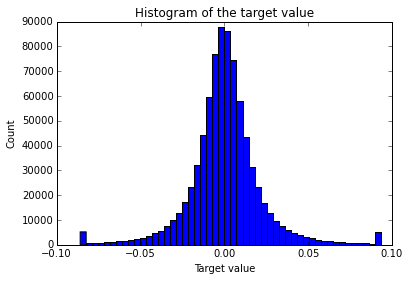

In [7]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

## Time series

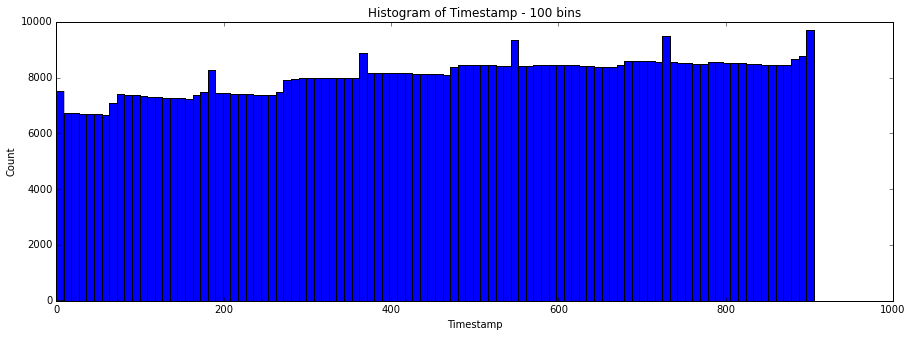

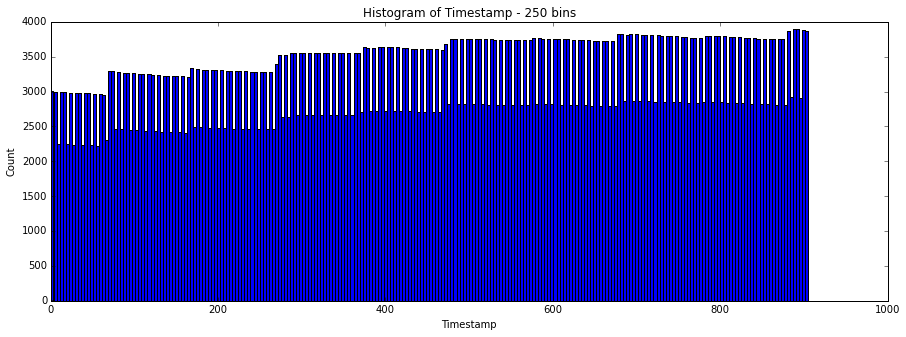

In [19]:
# Timestamp repartition
timestamp = o.train.timestamp.values
for bins in [100, 250]:
    plt.figure(figsize=(15, 5))
    plt.hist(timestamp, bins=bins)
    plt.xlabel("Timestamp")
    plt.ylabel("Count")
    plt.title("Histogram of Timestamp - {} bins".format(bins))

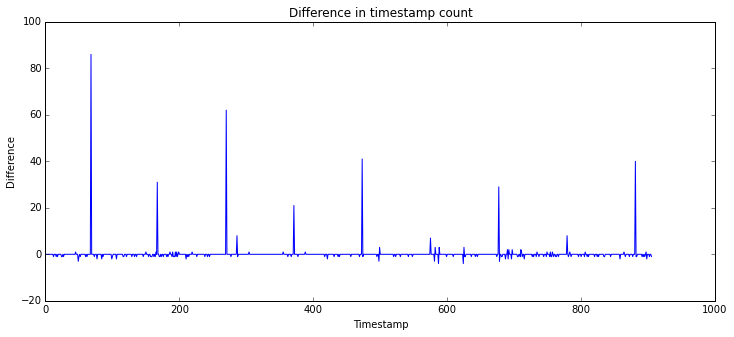

0      NaN
1     99.0
2    103.0
3    101.0
4    102.0
5    204.0
6    204.0
Name: timestamp, dtype: float64

In [3]:
time_diff = o.train.groupby(["timestamp"])["timestamp"].count().diff()

plt.figure(figsize=(12, 5))
plt.plot(time_diff)
plt.title("Difference in timestamp count")
plt.xlabel("Timestamp")
plt.ylabel("Difference")
plt.show()

pd.Series(time_diff[time_diff > 10].index).diff()

In [4]:
# Peaks can be approximated by 100*x + 70
time_diff[time_diff > 5]

timestamp
68     86.0
167    31.0
270    62.0
286     8.0
371    21.0
473    41.0
575     7.0
677    29.0
779     8.0
881    40.0
Name: timestamp, dtype: float64

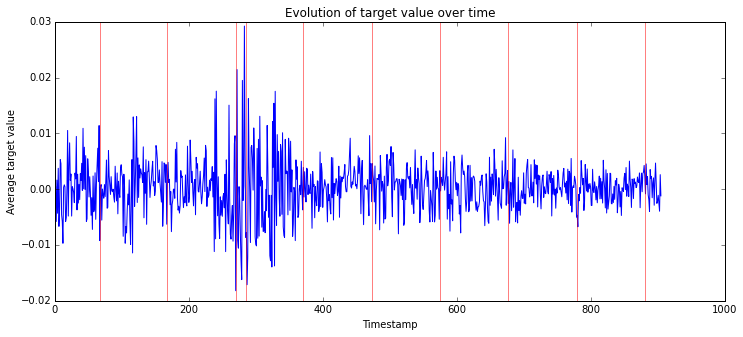

In [44]:
# Target value distribution over timestamp
y_distribution = o.train.groupby(["timestamp"])["y"].mean()
plt.figure(figsize=(12, 5))
plt.plot(y_distribution)
plt.xlabel("Timestamp")
plt.ylabel("Average target value")
plt.title("Evolution of target value over time")
for i in time_diff[time_diff > 5].index:
    plt.axvline(x=i, linewidth=0.5, color="red")
plt.show()

In [5]:
peak_dict = dict(((time_diff > 5).map(lambda x: 1 if x else 0)
                  + (time_diff > 10).map(lambda x: 1 if x else 0)))

In [67]:
peak_detector = RandomForestClassifier(max_depth=5, n_jobs=-1)
peak_detector.fit(np.array(o.train.loc[:, "timestamp"].values).reshape(-1, 1), 
                  o.train["timestamp"].apply(lambda x: peak_dict[x]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [72]:
peak_detector.predict_proba(np.array([981]).reshape(-1, 1))

array([[ 1.,  0.,  0.]])

## Models

In [3]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [6]:
# Fit an ExtraTreesRegressor
t0 = time()

extra_trees = ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, 
                          random_state=17, verbose=0)
model_2 = extra_trees.fit(train, o_train["y"])

train = []

print("Running time: {0}s.".format(time() - t0))

Running time: 3945.54212785s.


In [4]:
# Using pickle to save model.
#saved_model_2 = base64.standard_b64encode(bz2.compress(pk.dumps(model_2)))
#print(saved_model_2)

In [8]:
model_2_str = 

In [10]:
# Load saved model.
# Add "encoding="latin1" to the pk.loads method to decode in Python 3
warnings.simplefilter("ignore", UserWarning)
model_2 = pk.loads(bz2.decompress(base64.standard_b64decode(model_2_str)))
model_2

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=6,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=200, n_jobs=-1, oob_score=False, random_state=17,
          verbose=0, warm_start=False)

## Prediction

In [7]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

t0 = time()

while True:
    test = o.features.loc[:, col]
    # Total number of NA values per observation.
    test.loc[:, "is_null"] = test.isnull().sum(axis=1)
    
    # Fill NA values.
    for c in col:
        test.loc[:, c + "_nan"] = pd.isnull(test[c])

    test = test.fillna(d_mean)

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(reward)

print("Running time: {0}s.".format(time() - t0))

-0.317705048419
-0.18193433336
-0.168756452471
0.00933000256471
-0.122679162851
-0.166983884686
-0.209292035849
-0.30445458806
-0.0205499357463
('Finished', 0.021473779155142633)
Running time: 356.750163794s.


##Cross-validation

In [22]:
n_estimators_grid = [200, 300]
max_depth_grid = [5, 6]

score = []

t0 = time()

for n_estimators in n_estimators_grid:
    for max_depth in max_depth_grid:
        
        print("Parameters: \n     n_estimators:{0} \n     max_depth: {1}"\
              .format(n_estimators, max_depth))
        
        # The "environment" is our interface.
        env = kagglegym.make()

        # We get our initial observation by calling "reset".
        o = env.reset()

        excl = ["id", "timestamp", "y"]
        col = [c for c in o.train.columns if c not in excl]
        train = o.train.loc[:, col]

        # Total number of NA values per observation.
        train.loc[:, "is_null"] = train.isnull().sum(axis=1)

        # Record NA values and then fill them with the median.
        d_mean = train.median(axis=0)

        for c in col:
            train.loc[:, c + "_nan"] = pd.isnull(train[c])
            d_mean[c + "_nan"] = 0

        train = train.fillna(d_mean)
        
        # Model 1
        low_y_cut = -0.075
        high_y_cut = 0.075
        y_is_above_cut = (o.train.y > high_y_cut)
        y_is_below_cut = (o.train.y < low_y_cut)
        y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
        model_1 = LinearRegression(n_jobs=-1)
        model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1, 1), 
                    o.train.loc[y_is_within_cut, "y"])
        
        # Model 2
        extra_trees = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                                          n_jobs=-1, random_state=17, verbose=0)
        model_2 = extra_trees.fit(train, o.train["y"])

        ymean_dict = dict(o.train.groupby(["id"])["y"].median())

        while True:
            test = o.features.loc[:, col]
            # Total number of NA values per observation.
            test.loc[:, "is_null"] = test.isnull().sum(axis=1)

            # Fill NA values.
            for c in col:
                test.loc[:, c + "_nan"] = pd.isnull(test[c])

            test = test.fillna(d_mean)

            pred = o.target
            test_technical_20 = np.array(test["technical_20"].values).reshape(-1, 1)

            # Ponderation of the two models.
            pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                         + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
            # Add the median of the target value by ID.
            pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis=1)

            # The target values have 6 decimals in the training set.
            pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]

            o, reward, done, info = env.step(pred)
            if done:
                print("Finished", info["public_score"])
                break
            if o.features.timestamp[0] % 100 == 0:
                print(reward)
        
        score.append(info["public_score"])

        print("Running time: {0}s.".format(time() - t0))

Parameters: 
     n_estimators:200 
     max_depth: 5
-0.317612904033
-0.182022570997
-0.169765407348
0.0155721899717
-0.120887529213
-0.161751403784
-0.207983802147
-0.304530203505
-0.0193565919651
('Finished', 0.022544354775984359)
Running time: 1942.98224711s.
Parameters: 
     n_estimators:200 
     max_depth: 6
-0.317964370131
-0.181636354313
-0.170090172396
0.0210891114915
-0.122100133863
-0.15869220995
-0.208973403429
-0.304452852273
-0.0227012427798
('Finished', 0.023818689235850024)
Running time: 4134.09156013s.
Parameters: 
     n_estimators:300 
     max_depth: 5
-0.317710106052
-0.18212292887
-0.169783469952
0.0200483728335
-0.121449198546
-0.16200032081
-0.208525665085
-0.304498983443
-0.0229799518439
('Finished', 0.022265339569625051)
Running time: 6898.75451612s.
Parameters: 
     n_estimators:300 
     max_depth: 6
-0.318000512358
-0.18192592894
-0.170338108637
0.0224381742101
-0.123044219716
-0.158405005328
-0.210106180808
-0.304121947237
-0.0268123027067
('Finished', 

In [ ]:
#0.0148877463784 for model_1 only (8 mins)
#0.021473779155142633  for model_1 and model_2 (7 mins)

# First cross-validation
#Parameters: 
     #n_estimators:200 
     #max_depth: 5
#
#('Finished', 0.022544354775984359)

#Running time: 1942.98224711s.
#Parameters: 
     #n_estimators:200 
     #max_depth: 6
#('Finished', 0.023818689235850024)
#Running time: 4134.09156013s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 5
#('Finished', 0.022265339569625051)

#Running time: 6898.75451612s.
#Parameters: 
     #n_estimators:300 
     #max_depth: 6
#('Finished', 0.023778939527378237)
#Running time: 10013.6646042s.